In [7]:
%matplotlib inline
import torch
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import PIL
from models.AlexNet import *
from models.ResNet import *

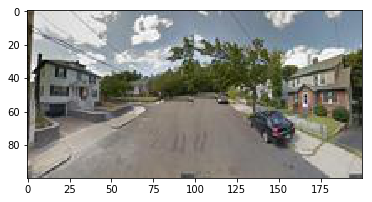

In [82]:
path='/home/fahad/data/streetContext/streetImages/Boston/modelRelated/data/resnetPOI/train/Neighborhood Residential/330596830.8779595228688447.jpg'
image = Image.open(path)
imshow(image)

In [83]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

base_transform = transforms.Compose([
    transforms.ToTensor()
    ])

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [85]:
tensor = base_transform(image)

In [86]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [87]:
startFromPath='/home/fahad/data/streetContext/streetImages/Boston/modelRelated/models/resnet18_check/resnet18_afterCleaning.999'
model = resnet_18()
model.load_state_dict(torch.load(startFromPath))

In [88]:
model.cuda()
model.eval()

ResNet(
  (Conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [89]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [90]:
final_layer = model._modules.get('layer4')

In [91]:
activated_features = SaveFeatures(final_layer)

In [92]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/home/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [93]:
topk(pred_probabilities,1)

(tensor([1.0000], device='cuda:0'), tensor([7], device='cuda:0'))

In [94]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [95]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [96]:
weight_softmax_params

[Parameter containing:
 tensor([[ 0.0658, -0.0549,  0.0629,  ...,  0.0639,  0.0415, -0.0346],
         [-0.0289,  0.0398, -0.0113,  ..., -0.0182,  0.0593,  0.0122],
         [ 0.0292,  0.0220,  0.0081,  ..., -0.0475,  0.0546,  0.0397],
         ...,
         [-0.0045, -0.0589, -0.0223,  ..., -0.0289, -0.0838, -0.0632],
         [-0.0243, -0.0735,  0.0058,  ..., -0.0378, -0.0726, -0.0654],
         [-0.0163, -0.0382,  0.0091,  ...,  0.0034, -0.0245, -0.0089]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-2.4676e-02, -1.9415e-02,  1.9300e-02, -6.3623e-03,  2.9797e-02,
          3.7338e-02,  3.4060e-02,  4.4332e-02,  3.5263e-02, -2.9570e-02,
         -5.5231e-02, -2.9376e-02, -7.3542e-02, -1.9151e-02, -5.1381e-02,
         -1.5858e-02, -4.1060e-02, -4.8100e-02, -3.1071e-03, -5.7156e-02,
         -7.3527e-02, -7.8471e-02, -5.4010e-02, -5.7693e-02, -4.1396e-02,
         -7.9913e-02, -5.9286e-02, -1.1978e-03, -2.8340e-02, -9.7996e-03,
         -7.3065e-03, -4

In [97]:
class_idx = topk(pred_probabilities,1)[1].int()
print(class_idx)

tensor([7], device='cuda:0', dtype=torch.int32)


In [98]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

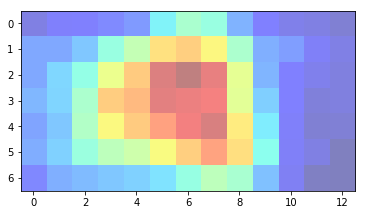

In [99]:
imshow(overlay[0], alpha=0.5, cmap='jet')

/home/fahad/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/fahad/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


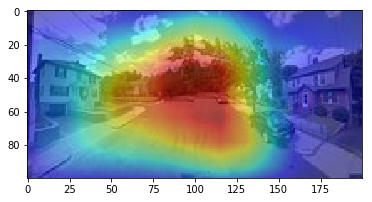

In [100]:
#imshow(display_transform(image))
imshow(image)
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

In [101]:
class_idx = topk(pred_probabilities,2)[1].int()

In [102]:
class_idx

tensor([7, 2], device='cuda:0', dtype=torch.int32)

In [103]:
overlay = getCAM(activated_features.features, weight_softmax, 2 )

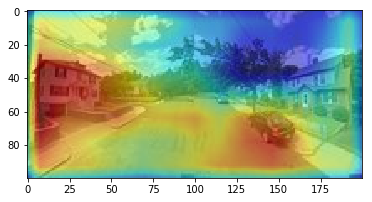

In [104]:
imshow((image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');